In [1]:

import os
import re
import glob
import importlib

import pandas as pd
import pylab as pl
import numpy as np
import seaborn as sns
import matplotlib.gridspec as gridspec


import utils as util
import plotting as putil
import importlib

In [2]:
putil.set_sns_style(style='dark', min_fontsize=12)

In [3]:
%matplotlib notebook

In [4]:
rootdir = '/mnt/minerva/courtship-videos'
# rootdir = '/mnt/sda/Videos'
assay='single_20mm_1x1'

sessionpaths = sorted(glob.glob(os.path.join(rootdir, assay, '202*')), key=util.natsort)
len(sessionpaths)

67

In [5]:
savedir = os.path.join('/mnt/minerva/analysis/FlyTracker/visualparams')
if not os.path.exists(savedir):
    os.makedirs(savedir)

In [6]:
#sess = [i for i in sessionpaths if '20220212-1150_ctns_3do_sh' in i][0]
no_trk=[]; found_trk=[];
for sess in sessionpaths:
    found_mats = glob.glob(os.path.join(sess, 'visualparams.mat'))
    if len(found_mats)==0:
        no_trk.append(os.path.split(sess)[-1])
    else:
        found_trk.append(os.path.split(sess)[-1])
print("Found {} of {} mat files.".format(len(found_trk), len(sessionpaths)))
print("No params/feats for {} files.".format(len(no_trk)))

Found 30 of 67 mat files.
No params/feats for 37 files.


In [7]:
d_list = []
for acq in found_trk:
    fpath = os.path.join(rootdir, assay, acq, 'visualparams.mat')
    df_ = util.load_mat_frames_and_var(fpath)
    df_['acquisition'] = acq
    
    # get species
    species_abbr = acq.split('_')[1]
    species_strain = 'na'
    if species_abbr.startswith('mau'):
        species_strain = species_abbr[3:]
        species_abbr = species_abbr[0:3]
    elif species_abbr in ('Canton-S', 'ctns'):
        species_abbr = 'mel'
        species_strain = 'cantons'
    # get age
    age = int(re.sub('\D', '', acq.split('_')[2]))
    
    df_['species'] = species_abbr
    df_['strain'] = species_strain
    df_['age'] = age
    
    d_list.append(df_)
df = pd.concat(d_list)
print(df.shape)
df.head()

(1212031, 22)


,Time Vector,Angular Position,Angular Size X,Angular Size Y,Angular Area,Angular Velocity,Diff Angular Size X,Diff Angular Size Y,Diff Angular Area,Metric Length X,...,Metric Relative Velocity,Size-to-Speed Ratio X,Size-to-Speed Ratio Y,Target Fly Orientation,Target Fly Major Axis,Target Fly Minor Axis,acquisition,species,strain,age
0,0.025,126.215348,6.832257,5.227215,28.049456,0.000000,0.000000,0.000000,0.000000,1.307698,...,0.000000,inf,inf,2.357483,2.524685,0.956938,20220128-1516_mauR4_4do_gh,mau,R4,4
1,0.050,125.374623,13.429388,5.370931,56.649450,-6.725799,52.777047,1.149732,228.799952,2.510054,...,-2.348057,-0.534496,-0.003447,2.458336,2.512030,0.988488,20220128-1516_mauR4_4do_gh,mau,R4,4
2,0.075,123.540591,14.453688,5.689812,64.590172,-14.672258,8.194398,2.551043,63.525777,2.551734,...,-4.786631,-0.266548,-0.001691,2.505228,2.553752,0.977887,20220128-1516_mauR4_4do_gh,mau,R4,4
3,0.100,123.495315,15.063291,5.789463,68.493291,-0.362205,4.876826,0.797212,31.224957,2.614710,...,-1.387788,-0.942042,-0.005832,2.308671,2.622319,0.991673,20220128-1516_mauR4_4do_gh,mau,R4,4
4,0.125,121.751773,14.881251,5.778187,67.533758,-13.948339,-1.456319,-0.090209,-7.676264,2.587799,...,0.154636,8.367414,0.052339,2.163029,2.625080,0.930344,20220128-1516_mauR4_4do_gh,mau,R4,4


In [8]:
acq

'20220530_Canton-S_age5_m_sh_f_gh_1'

## Load FEAT

In [9]:
f_list = []; t_list=[];
for i, sp in enumerate(found_trk):
    calib_, trk_, feat_ = util.load_flytracker_data(os.path.join(rootdir, assay, sp))
    if 'cop_ind' not in calib_.keys():
        print(sp, 'No cop')
    else:
        print(sp, calib_['cop_ind'])
    # get species
    species_abbr = sp.split('_')[1]
    species_strain = 'na'
    if species_abbr.startswith('mau'):
        species_strain = species_abbr[3:]
        species_abbr = species_abbr[0:3]
    elif species_abbr in ('Canton-S', 'ctns'):
        species_abbr = 'mel'
        species_strain = 'cantons'
    # get age
    age = int(re.sub('\D', '', sp.split('_')[2]))

    # get sex
    if float(feat_.groupby('id')['max_wing_ang'].mean().round(1).diff().abs().dropna()) == 0: # difference is super tiny
        ix_male = trk_.groupby('id')['body_area'].mean().idxmin() # use body size
    else:
        ix_male = feat_.groupby('id')['max_wing_ang'].mean().idxmax()
    feat_.loc[feat_['id']==ix_male, 'sex'] = 'm'
    feat_.loc[feat_['id']!=ix_male, 'sex'] = 'f'
    print('--', species_abbr, age, feat_['sex'].unique(), 'male ID: {}'.format(feat_[feat_['sex']=='m']['id'].unique()[0]))
        
    # update
    feat_['species'] = species_abbr
    feat_['strain'] = species_strain
    feat_['age'] = age
    feat_['acquisition'] = sp
    feat_['copulation_index'] = calib_['cop_ind']
    feat_['copulation'] = calib_['cop_ind']>0
    grab_index = calib_['cop_ind']-1 if calib_['cop_ind']>0 else feat_.iloc[-1].name
    f_list.append(feat_[feat_['frame']<=grab_index])
    # add trk, too
    trk_['acquisition'] = sp
    t_list.append(trk_[trk_['frame']<=grab_index])
feat = pd.concat(f_list) #.reset_index(drop=True)
trk = pd.concat(t_list)
feat.head()

20220128-1516_mauR4_4do_gh 0
-- mau 4 ['m' 'f'] male ID: 0
20220128-1555_mauR4_4do_gh 40631
-- mau 4 ['m' 'f'] male ID: 0
20220130-1125_ctns_4do_sh 13832
-- mel 4 ['m' 'f'] male ID: 0
20220130-1143_mauR_4do_sh 0
-- mau 4 ['m' 'f'] male ID: 0
20220202-0930_mauW_7do_sh 66420.0
-- mau 7 ['m' 'f'] male ID: 0
20220202-1013_yak_3do_sh 0
-- yak 3 ['m' 'f'] male ID: 0
20220202-1051_yak_3do_sh 0
-- yak 3 ['m' 'f'] male ID: 0
20220202-1146_rsim_7do_sh 0
-- rsim 7 ['m' 'f'] male ID: 0
20220202-1415_sant_7do_sh 0
-- sant 7 ['m' 'f'] male ID: 0
20220203-0912_sant_3do_sh 15320
-- sant 3 ['m' 'f'] male ID: 0
20220203-0951_sant_3do_sh 7085
-- sant 3 ['m' 'f'] male ID: 0
20220203-0955_mauR_7do_sh 32110
-- mau 7 ['m' 'f'] male ID: 0
20220203-1025_sant_3do_sh 19097
-- sant 3 ['m' 'f'] male ID: 0
20220203-1147_yak_7do_sh 62826
-- yak 7 ['m' 'f'] male ID: 0
20220212-1041_rsim_3do_sh 0
-- rsim 3 ['m' 'f'] male ID: 0
20220301_Canton-S_age5_m_sh_f_gh_1 9485
-- mel 5 ['m' 'f'] male ID: 0
20220301_Canton-S_age5

,vel,ang_vel,min_wing_ang,max_wing_ang,mean_wing_length,axis_ratio,fg_body_ratio,contrast,dist_to_wall,dist_to_other,...,fpath,frame,sec,sex,species,strain,age,acquisition,copulation_index,copulation
0,0.048078,0.009380,0.027638,0.038052,1.553808,2.272014,1.950244,0.230537,1.719942,10.978008,...,/mnt/minerva/courtship-videos/single_20mm_1x1/...,0,0.0,m,mau,R4,4,20220128-1516_mauR4_4do_gh,0.0,False
1,0.048078,0.024195,0.020374,0.020821,1.547737,2.276838,1.946842,0.228516,1.719942,10.585966,...,/mnt/minerva/courtship-videos/single_20mm_1x1/...,1,0.025,m,mau,R4,4,20220128-1516_mauR4_4do_gh,0.0,False
2,0.020837,0.070153,0.012663,0.017168,1.547325,2.278336,1.947520,0.228486,1.719942,10.164588,...,/mnt/minerva/courtship-videos/single_20mm_1x1/...,2,0.05,m,mau,R4,4,20220128-1516_mauR4_4do_gh,0.0,False
3,0.037862,0.085474,0.010313,0.013142,1.549365,2.280361,1.943649,0.229171,1.719942,9.938027,...,/mnt/minerva/courtship-videos/single_20mm_1x1/...,3,0.075,m,mau,R4,4,20220128-1516_mauR4_4do_gh,0.0,False
4,0.025148,0.055326,0.010339,0.013121,1.548967,2.281384,1.938447,0.229829,1.719942,10.069515,...,/mnt/minerva/courtship-videos/single_20mm_1x1/...,4,0.1,m,mau,R4,4,20220128-1516_mauR4_4do_gh,0.0,False


## Load binary behaviors from Matlab

In [10]:
basedir = '/mnt/minerva/analysis/FlyTracker'
# matlab_src = '/home/julianarhee/Documents/projects/flytracker-analysis/overviews2/Ddata.mat'
matlab_src = os.path.join(basedir, 'flytracker-matlab/overviews2/Ddata.mat')
# Set save dir
destdir = os.path.join(basedir, 'figures')
if not os.path.exists(destdir):
    os.makedirs(destdir)
# set FIGID
figid = 'flytracker-matlab/overviews2/Ddata.mat & visualparams.mat'

In [11]:
importlib.reload(util)

<module 'utils' from '/home/julianarhee/Repositories/flytracker/utils.py'>

In [12]:
events = util.load_binary_evs_from_mat(matlab_src, feat=feat)
events = util.add_bout_durations(events)

mauritiana 20220128-1516_mauR4_4do_gh


/home/julianarhee/anaconda3/envs/flytracker/lib/python3.8/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


mauritiana 20220128-1555_mauR4_4do_gh
mauritiana 20220130-1143_mauR_4do_sh
mauritiana 20220202-0930_mauW_7do_sh
mauritiana 20220203-0955_mauR_7do_sh
yakuba 20220202-1013_yak_3do_sh
yakuba 20220202-1051_yak_3do_sh
yakuba 20220203-1147_yak_7do_sh
santomea 20220202-1415_sant_7do_sh
santomea 20220203-0912_sant_3do_sh
santomea 20220203-0951_sant_3do_sh
santomea 20220203-1025_sant_3do_sh
melanogaster 20220130-1125_ctns_4do_sh
melanogaster 20220301_Canton-S_age5_m_sh_f_gh_1
melanogaster 20220301_Canton-S_age5_m_sh_f_gh_3
melanogaster 20220301_Canton-S_age5_m_sh_f_gh_4
melanogaster 20220301_Canton-S_age5_m_sh_f_gh_6
melanogaster 20220303_Canton-S_age4_m_sh_f_gh_7
melanogaster 20220307_Canton-S_age5_2
melanogaster 20220307_Canton-S_age5_3
melanogaster 20220307_Canton-S_age5_m_sh_f_gh_4_6
melanogaster 20220307_Canton-S_age5m_sh_f_gh_5
melanogaster 20220525_Canton-S_age4_m_sh_f_gh_1
melanogaster 20220525_Canton-S_age5_m_sh_f_age4_gh_2
melanogaster 20220525_Canton-S_age5_m_sh_f_age4_gh_4
melanogas

## Combine Visual params and Binary events

In [13]:
print([a for a, d_ in df.groupby('acquisition') if a not in events['acquisition'].unique()])
# acq = '20220525_Canton-S_age4_m_sh_f_gh_1'
# events[events['acquisition']==acq]

['20220212-1041_rsim_3do_sh', '20220525_Canton-S_age4_m_sh_f_gh_1']


In [14]:
curr_acqs = events['acquisition'].unique()
vparams = df[df['acquisition'].isin(curr_acqs)].copy()
vparams = vparams.rename(columns={'Time Vector': 'Time Vector (s)'})
print(vparams.shape, events.shape)

(1047407, 22) (1047407, 41)


In [15]:
vparams_behav = pd.merge(vparams, events, on=['Time Vector (s)', 'acquisition', 'species', 'strain', 'age'])
print(vparams_behav.shape)

(1047407, 58)


In [16]:
df.shape, events.shape

((1212031, 22), (1047407, 41))

In [17]:
# # acq = '20220128-1516_mauR4_4do_gh'
# acq= '20220203-1147_yak_7do_sh'
# #acq='20220301_Canton-S_age5_m_sh_f_gh_1'
# beh_ = vparams_behav[vparams_behav['acquisition']==acq].copy()
# beh_.shape

# Calculate bouts

In [18]:
import scipy.stats as spstats

In [40]:
m_list = []
for (acq, species), beh_ in vparams_behav.groupby(['acquisition', 'species']):
    if species=='rsim':
        continue
    mean_ = beh_.groupby('boutnum').mean().reset_index()
    mean_['Angular Position Circ'] = beh_.groupby('boutnum')['Angular Position'].apply(spstats.circmean, high=180, low=-180)
    beh_['Metric Relative Velocity Abs'] = beh_.groupby('boutnum')['Metric Relative Velocity'].apply(np.abs)
    mean_['Metric Relative Velocity Abs'] = beh_.groupby('boutnum')['Metric Relative Velocity Abs'].mean()
    mean_['acquisition'] = acq
    mean_['species'] = species
    m_list.append(mean_)
    
bouts = pd.concat(m_list).reset_index(drop=True)

In [41]:
# mean_[mean_['Left Wing Extensions']>0]['boutnum'].unique()

# behav = 'Right Wing Extensions'
# plotdf = mean_[mean_[behav]>0]

# plotdf[[x, y, z]]

# Plotting

In [20]:
species_list = bouts['species'].unique()
species_colors = sns.color_palette('colorblind', n_colors=len(species_list))

In [21]:
behavs2plot = ['Orienting', 'Chasing', 'Left Wing Extensions', 'Right Wing Extensions']

<IPython.core.display.Javascript object>


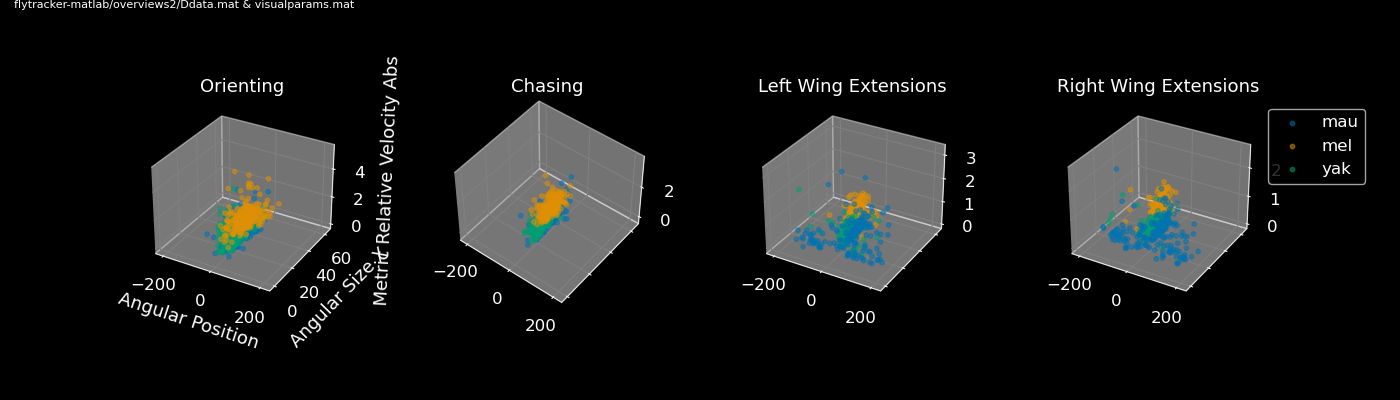

/mnt/minerva/analysis/FlyTracker/visualparams/3d-scatter_x-Angular Position_y-Angular Size X_z-Metric Relative Velocity Abs_mau-mel-yak.png


In [42]:
fig, axn= pl.subplots(1, len(behavs2plot), figsize=(14,4), subplot_kw={'projection': '3d'}, sharex=True, sharey=True)
#y = 'Metric Length X' # 'Angular Area'
#x = 'Metric Distance' #'Angular Position'
y = 'Angular Size X'
x = 'Angular Position'
z = 'Metric Relative Velocity Abs' #'Angular Velocity'

for ai, behav in enumerate(behavs2plot):
    ax=axn[ai]
    for col, sp in zip(species_colors, species_list):
        if sp=='sant':
            continue
        plotdf = bouts[(bouts['species']==sp) & (bouts[behav]>0)]
        ax.scatter(plotdf[x], plotdf[y], plotdf[z], color=col, alpha=0.5, s=10, label=sp)
    ax.set_title(behav)
    if ai == 0:
        ax.set_xlabel(x)
        ax.set_ylabel(y)
        ax.set_zlabel(z)
ax.legend(bbox_to_anchor=(1,1), loc='upper left')
pl.subplots_adjust(wspace=0.5, left=0.1, right=0.9)

putil.label_figure(fig, figid)
figname = '3d-scatter_x-{}_y-{}_z-{}_{}'.format(x, y, z, 'mau-mel-yak')
pl.savefig(os.path.join(savedir, '{}.png'.format(figname)))
print(os.path.join(savedir, '{}.png'.format(figname)))

<IPython.core.display.Javascript object>


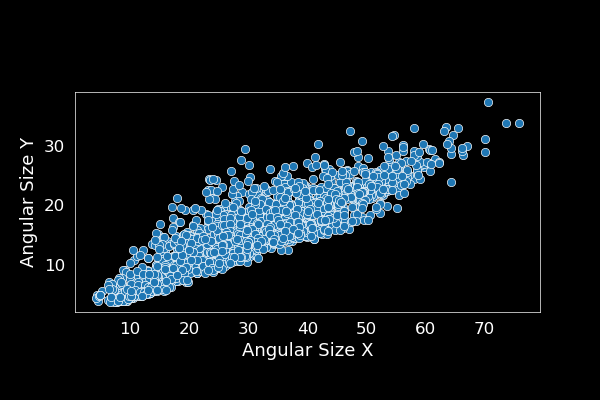

In [24]:
fig, ax = pl.subplots()
sns.scatterplot(data=bouts[bouts['Disengaged']==0], x='Angular Size X', y='Angular Size Y')
ax.set_aspect(1)

In [25]:
behavs2plot = ['Orienting', 'Chasing', 'Left Wing Extensions', 'Right Wing Extensions']

In [26]:
species_cdict = dict((k, v) for k, v in zip(species_list, species_colors))

<IPython.core.display.Javascript object>


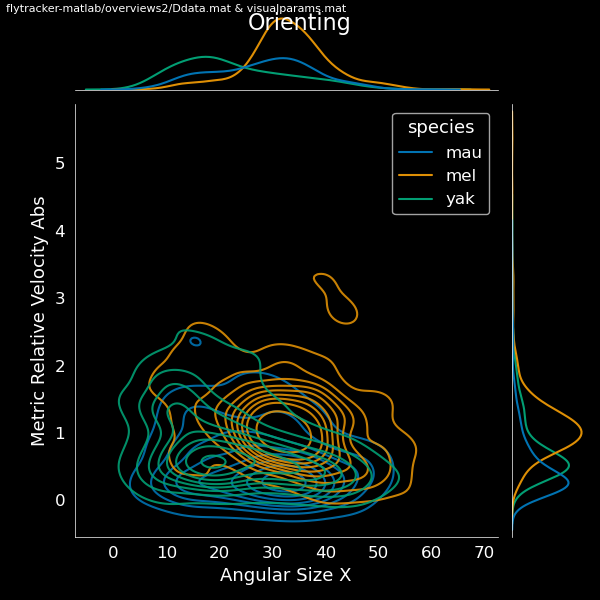

/home/julianarhee/anaconda3/envs/flytracker/lib/python3.8/site-packages/seaborn/distributions.py:1210: UserWarning: The following kwargs were not used by contour: 's'
  cset = contour_func(


/mnt/minerva/analysis/FlyTracker/visualparams/joint-Angular Size X-Metric Relative Velocity Abs_Orienting_mau-mel-yak.png


<IPython.core.display.Javascript object>


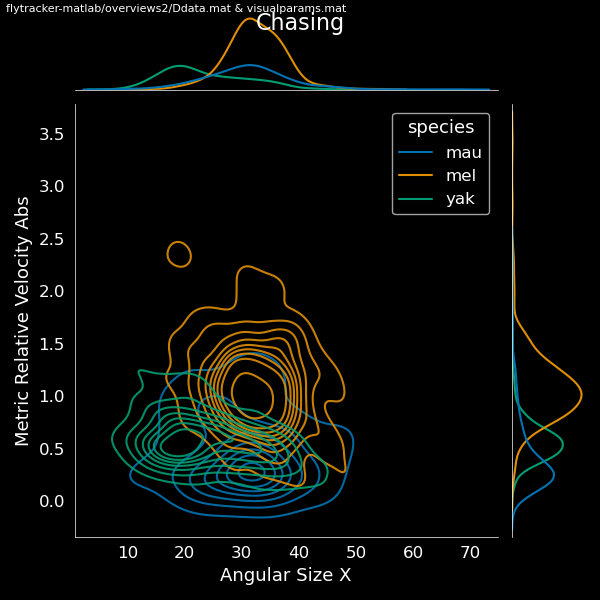

/home/julianarhee/anaconda3/envs/flytracker/lib/python3.8/site-packages/seaborn/distributions.py:1210: UserWarning: The following kwargs were not used by contour: 's'
  cset = contour_func(


/mnt/minerva/analysis/FlyTracker/visualparams/joint-Angular Size X-Metric Relative Velocity Abs_Chasing_mau-mel-yak.png


<IPython.core.display.Javascript object>


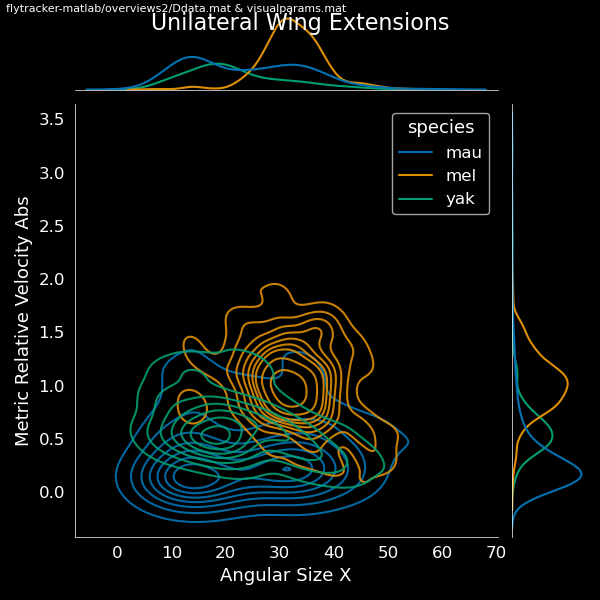

/home/julianarhee/anaconda3/envs/flytracker/lib/python3.8/site-packages/seaborn/distributions.py:1210: UserWarning: The following kwargs were not used by contour: 's'
  cset = contour_func(


/mnt/minerva/analysis/FlyTracker/visualparams/joint-Angular Size X-Metric Relative Velocity Abs_Unilateral Wing Extensions_mau-mel-yak.png


In [44]:
#fig, ax = pl.subplots(1, 1) #len(behavs2plot), figsize=(12,4), subplot_kw={'projection': '3d'})
#x = 'Angular Position' #'Angular Size X'
#y = 'Metric Length X' #'Angular Position' #'Metric Relative Velocity' 

behavs2plot = ['Orienting', 'Chasing', 'Unilateral Wing Extensions']

x = 'Angular Size X'
y = 'Metric Relative Velocity Abs'
for behav in behavs2plot:
    plotdf = bouts[bouts[behav]>0].copy()
    for curr_species in [['mau', 'mel', 'yak']]: #[['mau', 'mel'], ['yak', 'sant']]:
        plotdf1 = plotdf[plotdf['species'].isin(curr_species)]
        g = sns.jointplot(data=plotdf1, x=x, y=y, hue='species', palette=species_cdict,
                  kind='kde', joint_kws={'s': 10, 'alpha': 0.9})
        g.fig.suptitle(behav)

        figname = 'joint-{}-{}_{}_{}'.format(x, y, behav, '-'.join(curr_species))
        
        putil.label_figure(g.fig, figid)
        pl.savefig(os.path.join(savedir, '{}.png'.format(figname)))
        print(os.path.join(savedir, '{}.png'.format(figname)))

In [83]:
behav_colors

[(0.08605633600581403, 0.23824692404212, 0.30561236308077167),
 (0.32927729263408284, 0.4762845556584382, 0.1837155549758328),
 (0.8146245329198283, 0.49548316572322215, 0.5752525936416857),
 (0.7587183008012618, 0.7922069335474338, 0.9543861221913403)]

In [88]:
behav_colors

[(0.08523511613408935, 0.32661779003565533, 0.2973201282529313),
 (0.6328422475018423, 0.4747981096220677, 0.29070209208025455),
 (0.7779565181455343, 0.7069421942599752, 0.9314406084043191)]

In [103]:
bouts[x].max(), bouts[y].max()


(77.09965386378744, 14.193232051379242)

In [104]:
bouts[x].min(), bouts[y].min()


(4.264370865882899, 0.0035920323738461023)

<IPython.core.display.Javascript object>


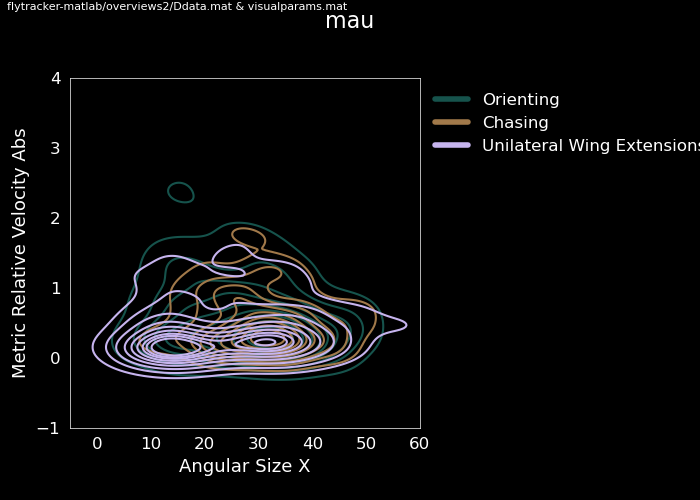

/home/julianarhee/anaconda3/envs/flytracker/lib/python3.8/site-packages/seaborn/distributions.py:1210: UserWarning: The following kwargs were not used by contour: 'lw'
  cset = contour_func(
/home/julianarhee/anaconda3/envs/flytracker/lib/python3.8/site-packages/seaborn/distributions.py:1210: UserWarning: The following kwargs were not used by contour: 'lw'
  cset = contour_func(
/home/julianarhee/anaconda3/envs/flytracker/lib/python3.8/site-packages/seaborn/distributions.py:1210: UserWarning: The following kwargs were not used by contour: 'lw'
  cset = contour_func(


/mnt/minerva/analysis/FlyTracker/visualparams/joint-Angular Size X-Metric Relative Velocity Abs_mau.png


<IPython.core.display.Javascript object>


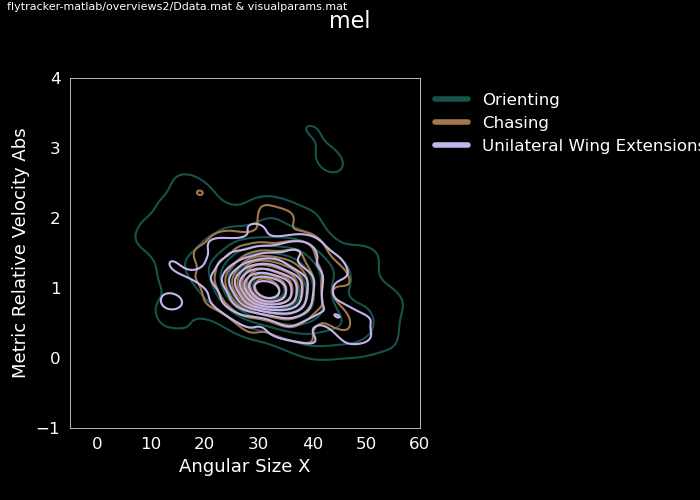

/home/julianarhee/anaconda3/envs/flytracker/lib/python3.8/site-packages/seaborn/distributions.py:1210: UserWarning: The following kwargs were not used by contour: 'lw'
  cset = contour_func(
/home/julianarhee/anaconda3/envs/flytracker/lib/python3.8/site-packages/seaborn/distributions.py:1210: UserWarning: The following kwargs were not used by contour: 'lw'
  cset = contour_func(
/home/julianarhee/anaconda3/envs/flytracker/lib/python3.8/site-packages/seaborn/distributions.py:1210: UserWarning: The following kwargs were not used by contour: 'lw'
  cset = contour_func(


/mnt/minerva/analysis/FlyTracker/visualparams/joint-Angular Size X-Metric Relative Velocity Abs_mel.png


<IPython.core.display.Javascript object>


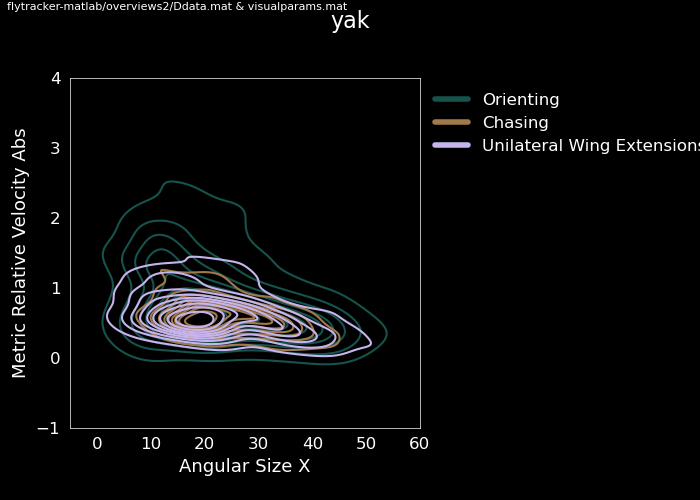

/home/julianarhee/anaconda3/envs/flytracker/lib/python3.8/site-packages/seaborn/distributions.py:1210: UserWarning: The following kwargs were not used by contour: 'lw'
  cset = contour_func(
/home/julianarhee/anaconda3/envs/flytracker/lib/python3.8/site-packages/seaborn/distributions.py:1210: UserWarning: The following kwargs were not used by contour: 'lw'
  cset = contour_func(
/home/julianarhee/anaconda3/envs/flytracker/lib/python3.8/site-packages/seaborn/distributions.py:1210: UserWarning: The following kwargs were not used by contour: 'lw'
  cset = contour_func(


/mnt/minerva/analysis/FlyTracker/visualparams/joint-Angular Size X-Metric Relative Velocity Abs_yak.png


In [112]:
#import SeabornFig2Grid as sfg

behavs2plot = ['Orienting', 'Chasing', 'Unilateral Wing Extensions']
behav_colors = sns.color_palette('cubehelix', n_colors=len(behavs2plot))
behav_cdict = dict((k, v) for k, v in zip(behavs2plot, behav_colors))

x = 'Angular Size X'
y = 'Metric Relative Velocity Abs'

for curr_species in ['mau', 'mel', 'yak']: #[['mau', 'mel'], ['yak', 'sant']]:
    plotdf1 = bouts[bouts['species'].isin([curr_species])]
    
    fig, ax = pl.subplots(figsize=(7,5))
    for ai, (col, behav) in enumerate(zip(behav_colors, behavs2plot)):
        plotdf = plotdf1[plotdf1[behav]>0].copy()
        sns.kdeplot(data=plotdf, x=x, y=y, color=col, ax=ax, label=behav,
                        alpha=1, lw=2, legend=1)
    ax.set_box_aspect(1)
    
    legh = putil.custom_legend(behavs2plot, behav_colors)
    ax.legend(handles=legh, loc='upper left', bbox_to_anchor=(1,1), frameon=False)
    
    ax.set_xlim([-5, 60]) #np.ceil(bouts[x].max())])
    ax.set_ylim([-1, 4]) #np.ceil(bouts[y].max())])

    
    pl.subplots_adjust(left=0.1, right=0.6)
    fig.suptitle(curr_species)
    #g.fig.suptitle(behav)
    figname = 'joint-{}-{}_{}'.format(x, y, curr_species)

    putil.label_figure(fig, figid)
    pl.savefig(os.path.join(savedir, '{}.png'.format(figname)))
    print(os.path.join(savedir, '{}.png'.format(figname)))

## Color by behavior for each species

In [232]:
non_behav_cols = [c for c in bouts.columns if c not in behavs2plot]

In [236]:
melted_bouts = pd.melt(bouts[bouts['Disengaged']==0], id_vars=non_behav_cols, value_vars=behavs2plot, var_name='behavior', value_name='fraction_of_bout')

In [255]:
bouts[bouts['boutnum']==1][[x, 'Orienting']]

,Metric Distance,Orienting
1,13.093747,0.000000
313,3.585707,0.714286
437,2.110105,0.590909
595,3.218086,1.000000
889,1.968769,0.000000
1597,11.942084,0.000000
2100,10.950500,1.000000
2437,4.085986,0.000000
2588,9.659978,1.000000
2662,11.656987,1.000000


<IPython.core.display.Javascript object>


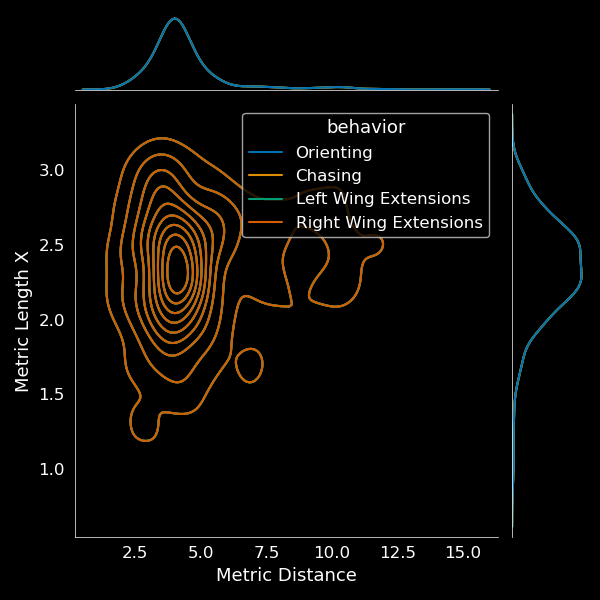

In [245]:
#fig, ax = pl.subplots()
plotdf = melted_bouts[melted_bouts['species']=='mel']
g = sns.jointplot(data=plotdf, x=x, y=y, hue='behavior', #palette='colorblind', 
                 kind='kde')

<IPython.core.display.Javascript object>


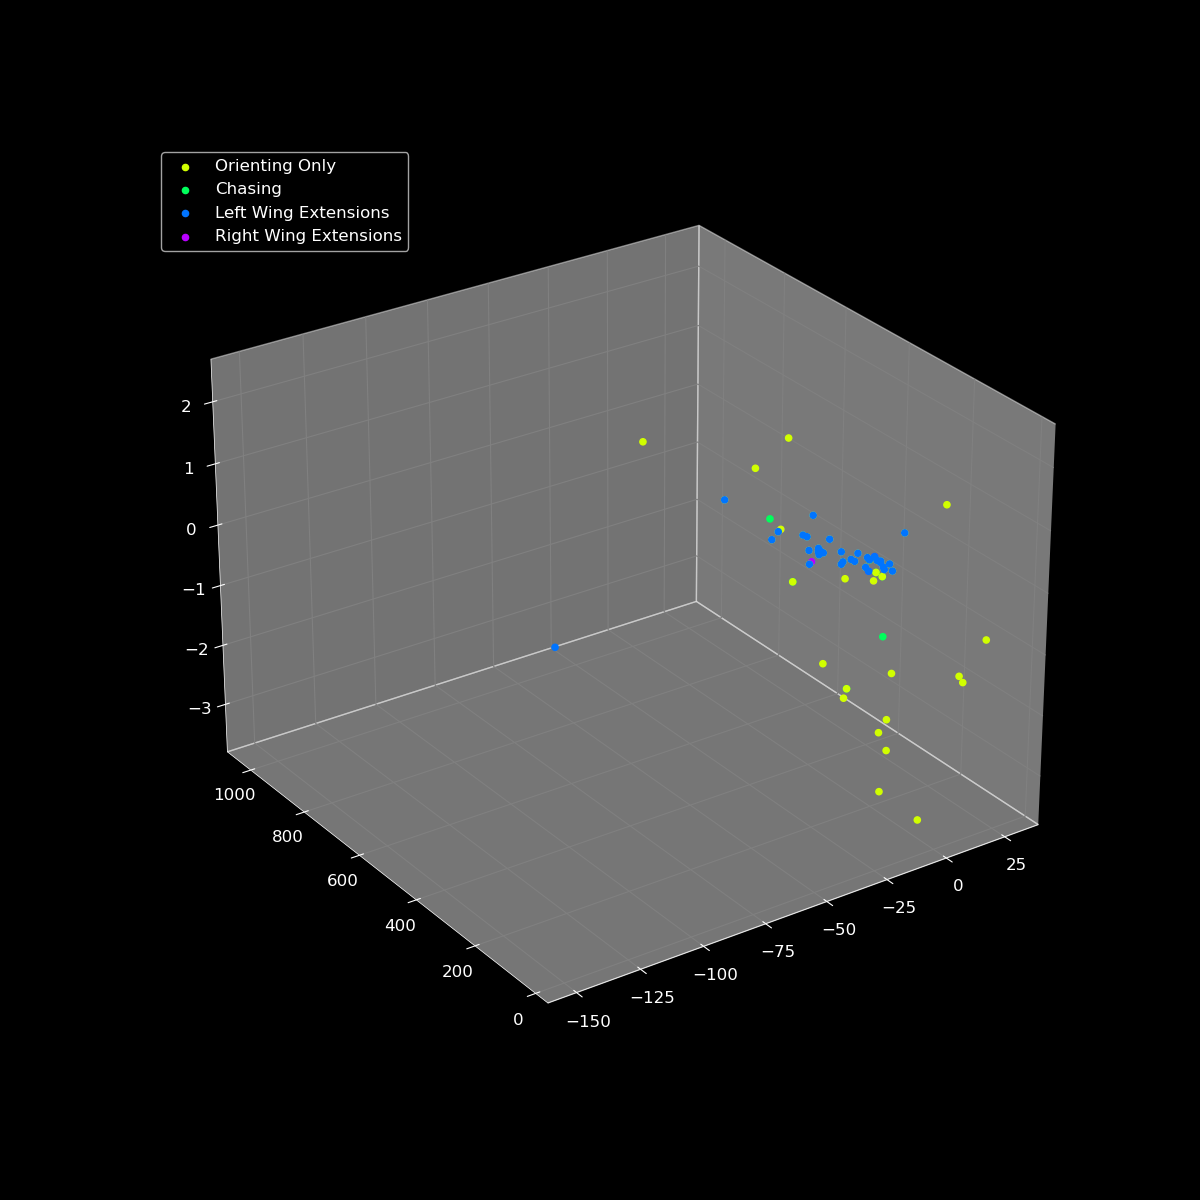

In [143]:
#fig, axn = pl.subplots(1, len(behavs2plot), figsize=(12,4), subplot_kw={'projection': '3d'})
fig, ax = pl.subplots(1, 1, figsize=(12,12), subplot_kw={'projection': '3d'})

y = 'Angular Area'
x = 'Angular Position'
z = 'Metric Relative Velocity' #'Angular Velocity'

for ai, (col, behav) in enumerate(zip(colors, behavs2plot)):
    #ax=axn[ai]
    plotdf = mean_[mean_[behav]>0]
    ax.scatter(plotdf[x], plotdf[y], plotdf[z], color=col, alpha=1, s=20, label=behav)
    # sns.scatterplot(data=plotdf, y=y, x=x, ax=ax, label=behav,
    #                 hue=z, palette='PuBuGn', size=z,  #hue_norm=(-10, 10),
    #                alpha=0.2, edgecolor='none')
    #ax.set_title(behav)
    ax.legend(bbox_to_anchor=(0, 1), loc='upper left')

In [98]:
beh_[beh_['boutnum']==11][['Orienting', 'Chasing', 'Unilateral Wing Extensions', 'Putative Tap Events','Licking/Proboscis Ext', 'Copulation Attempts', 'Disengaged']]

,Orienting,Chasing,Unilateral Wing Extensions,Putative Tap Events,Licking/Proboscis Ext,Copulation Attempts,Disengaged
673844,0.0,0.0,0,1.0,0.0,0.0,0.0
673845,0.0,0.0,0,1.0,0.0,0.0,0.0


In [114]:
beh_[beh_['boutnum']==25][['Angular Position']]

,Angular Position
678809,25.917500
678810,20.976569
678811,18.828412
678812,14.547227
678813,13.841647
...,...
678941,30.000047
678942,30.449236
678943,29.700249
678944,30.119232


In [ ]:
spstats.cir

# plot

In [83]:
behavs2plot = ['Orienting Only', 'Chasing', 'Left Wing Extensions', 'Right Wing Extensions']
colors = sns.color_palette('hsv', n_colors=len(behavs2plot))

<IPython.core.display.Javascript object>


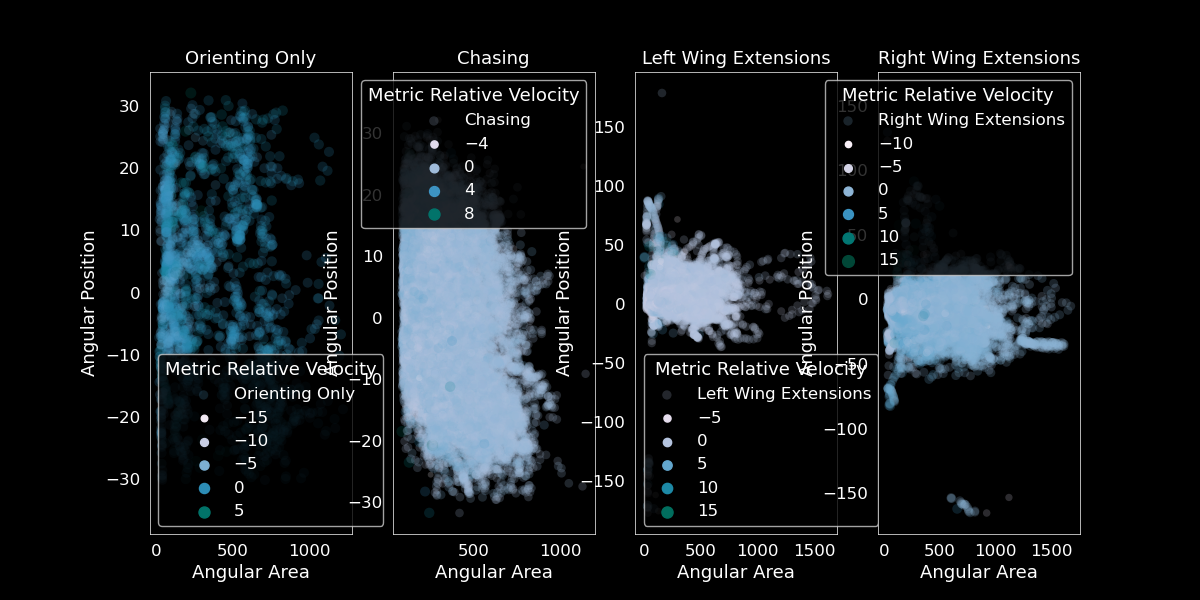

In [84]:
fig, axn = pl.subplots(1, len(behavs2plot), figsize=(12,6)) #,subplot_kw={'projection': '3d'})
x = 'Angular Area'
y = 'Angular Position'
z = 'Metric Relative Velocity' #'Angular Velocity'

for ai, (col, behav) in enumerate(zip(colors, behavs2plot)):
    ax=axn[ai]
    plotdf = beh_[beh_[behav]==1]
    #ax.scatter(plotdf[x], plotdf[y], plotdf[z], color=col)
    sns.scatterplot(data=plotdf, y=y, x=x, ax=ax, label=behav,
                    hue=z, palette='PuBuGn', size=z,  #hue_norm=(-10, 10),
                   alpha=0.2, edgecolor='none')
    ax.set_title(behav)
    #ax.legend_.remove()
    #ax.set_xlim([-50, 50])
    #ai+=1
    #ax.set_zscale("log")

<IPython.core.display.Javascript object>


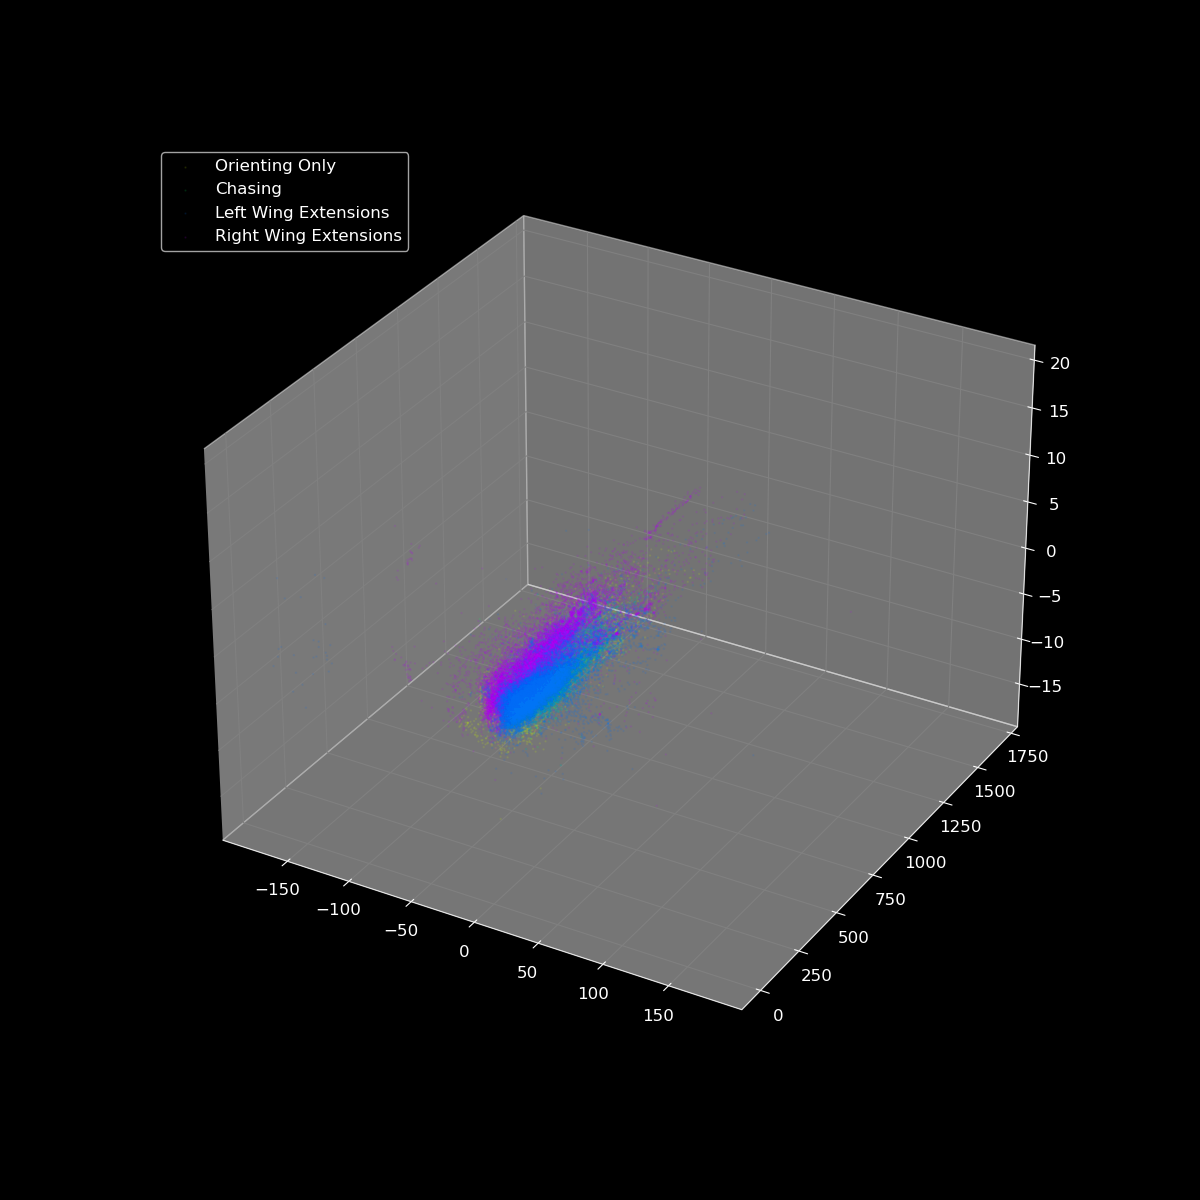

In [66]:
#fig, axn = pl.subplots(1, len(behavs2plot), figsize=(12,4), subplot_kw={'projection': '3d'})
fig, ax = pl.subplots(1, 1, figsize=(12,12), subplot_kw={'projection': '3d'})

y = 'Angular Area'
x = 'Angular Position'
z = 'Metric Relative Velocity' #'Angular Velocity'


for ai, (col, behav) in enumerate(zip(colors, behavs2plot)):
    #ax=axn[ai]
    plotdf = beh_[beh_[behav]==1]
    ax.scatter(plotdf[x], plotdf[y], plotdf[z], color=col, alpha=0.1, s=0.5, label=behav)
    # sns.scatterplot(data=plotdf, y=y, x=x, ax=ax, label=behav,
    #                 hue=z, palette='PuBuGn', size=z,  #hue_norm=(-10, 10),
    #                alpha=0.2, edgecolor='none')
    #ax.set_title(behav)
    ax.legend(bbox_to_anchor=(0, 1), loc='upper left')

<IPython.core.display.Javascript object>


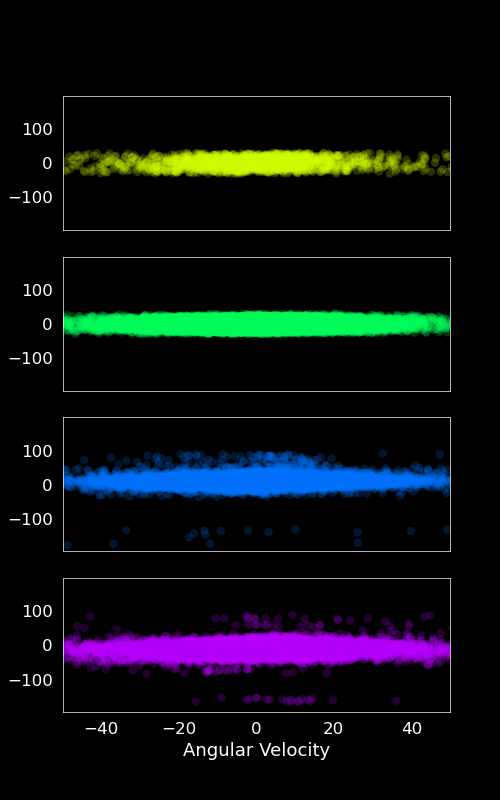

In [30]:

fig, axn = pl.subplots(len(behavs2plot), 1, figsize=(5,8), sharex=True, sharey=True)
x = 'Angular Velocity' #'Metric Relative Velocity'
y = 'Angular Position' #'Angular Area' 
ai = 0
for col, behav in zip(colors, behavs2plot):
    ax=axn[ai]
    plotdf = beh_[beh_[behav]==1]
    sns.scatterplot(data=plotdf, y=y, x=x, color=col, ax=ax, label=behav,
                   alpha=0.2, edgecolor='none')
    ax.legend_.remove()
    ax.set_xlim([-50, 50])
    ai+=1

<IPython.core.display.Javascript object>


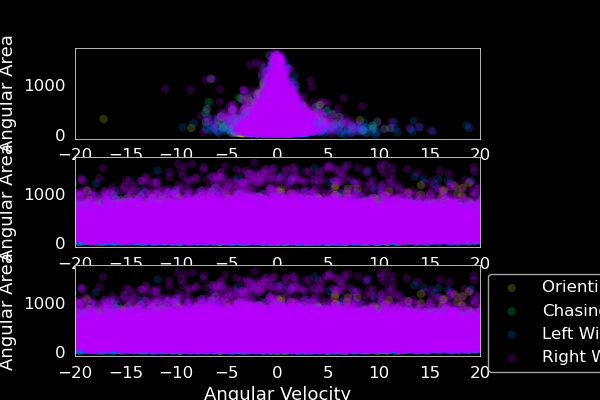

In [49]:
fig, axn = pl.subplots(3, 1)
behavs2plot = ['Orienting Only', 'Chasing', 'Left Wing Extensions', 'Right Wing Extensions']
colors = sns.color_palette('hsv', n_colors=len(behavs2plot))

ax=axn[0]
x = 'Metric Relative Velocity'
y = 'Angular Area' 
for col, behav in zip(colors, behavs2plot):
    plotdf = beh_[beh_[behav]==1]
    sns.scatterplot(data=plotdf, y=y, x=x, color=col, ax=ax, label=behav,
                   alpha=0.2, edgecolor='none')
    ax.legend_.remove()
    

ax=axn[1]
x = 'Angular Velocity'
y = 'Angular Area'
for col, behav in zip(colors, behavs2plot):
    plotdf = beh_[beh_[behav]==1]
    sns.scatterplot(data=plotdf, y=y, x=x, color=col, ax=ax, label=behav,
                   alpha=0.2, edgecolor='none')
    ax.legend_.remove()


ax=axn[2]
x = 'Angular Velocity'
y = 'Angular Area'
for col, behav in zip(colors, behavs2plot):
    plotdf = beh_[beh_[behav]==1]
    sns.scatterplot(data=plotdf, y=y, x=x, color=col, ax=ax, label=behav,
                   alpha=0.2, edgecolor='none')
    sns.move_legend(ax, loc='upper left', bbox_to_anchor=(1,1))

for ax in axn.flat:
    #ax.set_box_aspect(1)
    ax.set_xlim([-20, 20])
pl.subplots_adjust(right=0.8)
